# DATA20001 Deep Learning - Group Project
## Image project

**Due Thursday, December 13, before 23:59.**

The task is to learn to assign the correct labels to a set of images.  The images are originally from a photo-sharing site and released under Creative Commons-licenses allowing sharing.  The training set contains 20 000 images. We have resized them and cropped them to 128x128 to make the task a bit more manageable.

We're only giving you the code for downloading the data. The rest you'll have to do yourselves.

Some comments and hints particular to the image project:

- One image may belong to many classes in this problem, i.e., it's a multi-label classification problem. In fact there are images that don't belong to any of our classes, and you should also be able to handle these correctly. Pay careful attention to how you design the outputs of the network (e.g., what activation to use) and what loss function should be used.

- As the dataset is pretty imbalanced, don't focus too strictly on the outputs being probabilistic. (Meaning that the right threshold for selecting the label might not be 0.5.)

- Image files can be loaded as numpy matrices for example using `imread` from `matplotlib.pyplot`. Most images are color, but a few grayscale. You need to handle the grayscale ones somehow as they would have a different number of color channels (depth) than the color ones.

- In the exercises we used e.g., `torchvision.datasets.MNIST` to handle the loading of the data in suitable batches. Here, you need to handle the dataloading yourself.  The easiest way is probably to create a custom `Dataset`. [See for example here for a tutorial](https://github.com/utkuozbulak/pytorch-custom-dataset-examples).

In [0]:
! pip install torch torchvision torchsummary

    100% |████████████████████████████████| 591.8MB 23kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x61052000 @  0x7f77e6e552a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 25.7MB/s 
    100% |████████████████████████████████| 2.0MB 5.3MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

    100% |████████████████████████████████| 5.7MB 7.2MB/s 
  Found existing installation: Pillow 5.4.0
    Uninstalling Pillow-5.4.0:
      Successfully uninstalled Pillow-5.4.0


## Download the data

In [0]:
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
import zipfile

In [0]:
train_path = 'train'
dl_file = 'dl2018-image-proj.zip'
dl_url = 'https://users.aalto.fi/mvsjober/misc/'

zip_path = os.path.join(train_path, dl_file)
if not os.path.isfile(zip_path):
    download_url(dl_url + dl_file, root=train_path, filename=dl_file, md5=None)

with zipfile.ZipFile(zip_path) as zip_f:
    zip_f.extractall(train_path)
    #os.unlink(zip_path)

In [3]:
if torch.cuda.is_available():
    print('Using GPU!')
    device = torch.device('cuda')
else:
    print('Using CPU')
    device = torch.device('cpu')

Using GPU!


The above command downloaded and extracted the data files into the `train` subdirectory.

The images can be found in `train/images`, and are named as `im1.jpg`, `im2.jpg` and so on until `im20000.jpg`.

The class labels, or annotations, can be found in `train/annotations` as `CLASSNAME.txt`, where CLASSNAME is one of the fourteen classes: *baby, bird, car, clouds, dog, female, flower, male, night, people, portrait, river, sea,* and *tree*.

Each annotation file is a simple text file that lists the images that depict that class, one per line. The images are listed with their number, not the full filename. For example `5969` refers to the image `im5969.jpg`.

## Your stuff goes here ...

In [0]:
import os
from os import listdir
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random as rd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
img_path = "./train/images/"
labels_path = "./train/annotations/"

Get all annotations & images paths

In [0]:
images_path = "train/images/" 
image_files = [(images_path+f) for f in os.listdir(images_path) \
                if os.path.isfile(os.path.join(images_path, f))]
images = []
for current_img_path in image_files:
    current_img_vector =  plt.imread( current_img_path )
    filename_without_extension = os.path.basename(current_img_path)[:-4] # :-4 to drop the extension
    img_num = filename_without_extension[2:] # drop the heading "im"
    images += [img_num]
del image_files

In [0]:
data=images
labels = [[] for _ in range(len(data))] # Empty list of labels
annotations_path = "train/annotations/"
annotations_files = [(annotations_path+f) for f in os.listdir(annotations_path) \
        if os.path.isfile(os.path.join(annotations_path, f))]
for file in annotations_files:
    label = os.path.basename(file)[:-4] # :-4 to drop the extension
    with open(file) as f: # file is the name of the label currently read
        img_nums = f.read().split()
    for img_num in img_nums:
        if img_num not in data:
            continue
        labels[data.index(img_num)].append(label)

In [0]:
class OneHotTransformer:
    def __init__(self):
        annotations_files = [(annotations_path+f) for f in os.listdir(annotations_path) \
                    if os.path.isfile(os.path.join(annotations_path, f))]
        self.vocabulary = []
        for file in annotations_files:
            label = os.path.basename(file)[:-4] # :-4 to drop the extension
            self.vocabulary.append(label)
    def toOneHot(self, labels):
        res = [0]*len(self.vocabulary)
        for i, voc in enumerate(self.vocabulary):
            if voc in labels:
                res[i] = 1
        return np.array(res)
    def toVocabulary(self, onehot):
        res = []
        for i, n in enumerate(onehot):
            if n: res.append(self.vocabulary[i])
        return res
oneHotTransformer = OneHotTransformer()

In [0]:
# Files to pytorch dataset
# Inspired from https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py
from torch.utils.data.dataset import Dataset
from torchvision import datasets, transforms
from PIL import Image

class imageDataset(Dataset):
    def __init__(self, data_basenames, channels = 3, height = 224, width = 224, transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])):
        """
        data_basenames is a list of id of image, such as ["9885", "9886"]
        transforms is a list of transformation. it last element should be transforms.ToTensor()
        """
        def parse_labels(data_paths):
            """ Parse to one hot """
            labels = [[] for _ in range(len(data_paths))] # Empty list of labels
            annotations_path = "train/annotations/"
            annotations_files = [(annotations_path+f) for f in os.listdir(annotations_path) \
                    if os.path.isfile(os.path.join(annotations_path, f))]
            vocabulary = []
            for file in annotations_files:
                label = os.path.basename(file)[:-4] # :-4 to drop the extension
                vocabulary.append(label)
                with open(file) as f: # file is the name of the label currently read
                    img_nums = f.read().split()
                for img_num in img_nums:
                    if img_num not in data_paths:
                        continue
                    labels[data_paths.index(img_num)].append(label)
            return labels
          
        self.data = data_basenames
        self.labels = parse_labels(data_basenames)
        self.channels = channels
        self.height = height
        self.width = width
        self.transforms = transforms
        self.data_len = len(data_basenames)

    def __getitem__(self, index):
        img_path = "train/images/im" + self.data[index] + ".jpg"
        data = Image.open(img_path)
        
        if self.transforms is not None:
            img = self.transforms(data)
        #labels = np.array(self.labels[index])
        #print(self.labels[index])
        
        if img.shape[0] == 1:  # change graysclae images to RGB
            img = torch.cat((img,img,img),0)      
        labels = self.labels[index]
        one_hot_labels = oneHotTransformer.toOneHot(labels)
        return img, one_hot_labels

    def __len__(self):
        return self.data_len

    
import random
random.shuffle(images) # So we make sure test data has all kinds of label, in case
                                 # the repartition is not even according to label names

batch_size = 16

# 80% train, 20% test
index_cut =  int(len(images)*0.8)
train_dataset = imageDataset(images[:index_cut])
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
test_dataset = imageDataset(images[index_cut:])
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [0]:
data, target = next(train_loader.__iter__()) # Iteration works!

# Pretrained Models



## 1.1 Resnet

In [0]:
import torchvision.models as models

resnet18 = models.resnet18(pretrained=True)
num_input = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_input, 14)
model = resnet18.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 

Train the model

In [0]:
def train_net(model, epoch, trainLoss, thresh, interval = 100):
    # set model to train
    model.train()
    loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data = data.to(device) # to GPU
        target = target.float().to(device) # to GPU, ".float()" is improtant, otherwise got error.
        
        # set zero gradient buffer
        optimizer.zero_grad()
        
        # compute the output and Loss
        output = model(data)
        Loss = criterion(output, target)
        
        # back prop
        Loss.backward()
        
        # update weights
        optimizer.step()
        
        # print information
        if batch_idx % interval == 0:
            print("Train Epoch: {} [{}/{} {:.0f}%]\tLoss: {:.6f}".format(epoch, len(data)*batch_idx, len(train_loader)*len(data), batch_idx/len(train_loader)*100, Loss.data.item()))   
         
        loss += Loss
        
    loss/=len(train_loader)
    
    trainLoss.append(loss)

In [15]:
def validate(model, treshold, lossv, accv, precv, recv, verbose=True):
  loss, acc, prec, rec = 0,0,0,0
  for i, sample in enumerate(test_loader):
    inputv, targetv = sample
    inputv = inputv.to(device)
    output = model(inputv)
    
    pred = torch.sigmoid(output).data.gt(treshold) # Activated output
    #loss += criterion(output, target.float().to(device))
    loss += criterion(output, targetv.data.to(device).float()).data.item()
    # confusion matrix (true/false negative/positive)
    tp = (pred + targetv.data.to(device).byte()).eq(2).sum()
    fp = (pred - targetv.data.to(device).byte()).eq(1).sum()
    fn = (pred - targetv.data.to(device).byte()).eq(-1).sum()
    tn = (pred + targetv.data.to(device).byte()).eq(0).sum()
    acc += (tp + tn).float() / (tp + tn + fp + fn)

    if tp+fp!=0:
      prec += tp.float() / (tp + fp)
    else:
      prec += 0.0
    if tp+fn != 0:
      rec += tp.float() / (tp + fn)
    else:
      rec += 0.0
  loss /= len(test_loader)
  acc /= len(test_loader)
  prec /= len(test_loader)
  rec /= len(test_loader)
  lossv.append(loss)
  accv.append(acc)
  precv.append(prec)
  recv.append(rec)
  if verbose:
    print('Validation set: Average loss: {:.4f}, Accuracy: {:.2f}%, Precision: {:.2f}%, Recall: {:.2f}%'.format(
            loss, acc*100, prec*100, rec*100))
    print("\t\tF1 score : {:.2f}%\n".format(100*2*(prec*rec)/(prec+rec)))
lossv, accv, precv, recv = [],[],[],[] # Average loss, accuracy, precision and recall
validate(model, 0.5, lossv, accv, precv, recv)

Validation set: Average loss: 0.6878, Accuracy: 60.76%, Precision: 6.85%, Recall: 36.39%
		F1 score : 11.53%



In [16]:
%%time
#model = one_layer_cnn().to(device)
#model = sim_cnn_v1().to(device)
#model = deep_cnn().to(device)
#model = lstm()
treshold = 0.3
epoch = 3

#learning_rate = 0.000001 # for sim_cnn_v1
learning_rate = 0.0001 # for deep_cnn
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()
#criterion = nn.BCELoss()
train_loss, val_loss = [], []
accuracy, precision, recall = [],[],[]
for i in range(1,1+epoch):
    train_net(model, i, train_loss, treshold)
    validate(model, treshold, val_loss, accuracy, precision, recall)
    
    if i>3:
      prev_delta_loss = abs(val_loss[-2] - train_loss[-2]) 
      delta_loss = abs(val_loss[-1] - train_loss[-1])
      if delta_loss > prev_delta_loss:
        # The model starts to be overfitted
        #if delta_loss<0.01:
        #  break # We consider a 0.01 delta loss good enough
        #elif delta_loss<0.5: 
        #  print("Smaller learning rate!")
        #  learning_rate /= 10 # Dividing the learning rate
        # optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 
        pass

Train Epoch: 1 [0/16000 0%]	Loss: 0.669185
Train Epoch: 1 [1600/16000 10%]	Loss: 0.129752
Train Epoch: 1 [3200/16000 20%]	Loss: 0.100199
Train Epoch: 1 [4800/16000 30%]	Loss: 0.138288
Train Epoch: 1 [6400/16000 40%]	Loss: 0.093162
Train Epoch: 1 [8000/16000 50%]	Loss: 0.084986
Train Epoch: 1 [9600/16000 60%]	Loss: 0.124405
Train Epoch: 1 [11200/16000 70%]	Loss: 0.138449
Train Epoch: 1 [12800/16000 80%]	Loss: 0.058272
Train Epoch: 1 [14400/16000 90%]	Loss: 0.089801
Validation set: Average loss: 0.1021, Accuracy: 95.80%, Precision: 68.55%, Recall: 74.15%
		F1 score : 71.24%

Train Epoch: 2 [0/16000 0%]	Loss: 0.085925
Train Epoch: 2 [1600/16000 10%]	Loss: 0.047930
Train Epoch: 2 [3200/16000 20%]	Loss: 0.136016
Train Epoch: 2 [4800/16000 30%]	Loss: 0.071187
Train Epoch: 2 [6400/16000 40%]	Loss: 0.050727
Train Epoch: 2 [8000/16000 50%]	Loss: 0.056515
Train Epoch: 2 [9600/16000 60%]	Loss: 0.115537
Train Epoch: 2 [11200/16000 70%]	Loss: 0.071884
Train Epoch: 2 [12800/16000 80%]	Loss: 0.062257

In [18]:
# Have a look at results
# So we can know what error is common
for i, sample in enumerate(test_loader):
    inputv, targetv = sample
    inputv = inputv.to(device)
    output = model(inputv)
    
    #print("Prediction\n", output)
    pred = output.data.gt(treshold) # Activated output
    print("Prediction\n", pred)
    print("Truth\n", targetv)
    break

Prediction
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], device='cuda:0',
       dtype=torch.uint8)
Truth
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 

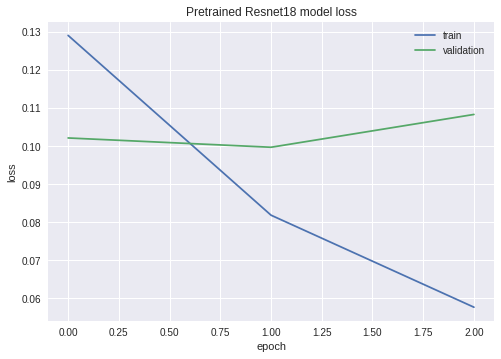

In [17]:
# The schema allows to see if the model was properly fitted
# that allows us to learn if the initial learning rate was appropriate
plt.title("Pretrained Resnet18 model loss")
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="validation")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

## 1.2 VGG16

In [0]:
# VGG16,slow
vgg16 = models.vgg16(pretrained=True)

num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1]
features.extend([nn.Linear(num_features, 14)])
vgg16.classifier = nn.Sequential(*features)

model = vgg16.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) #Adam
criterion = nn.MultiLabelSoftMarginLoss() 

In [0]:
def train_net(model, epoch, trainLoss, thresh, interval = 100):
    # set model to train
    model.train()
    loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data = data.to(device) # to GPU
        target = target.float().to(device) # to GPU, ".float()" is improtant, otherwise got error.
        
        # set zero gradient buffer
        optimizer.zero_grad()
        
        # compute the output and Loss
        output = model(data)
        Loss = criterion(output, target)
        
        # back prop
        Loss.backward()
        
        # update weights
        optimizer.step()
        
        # print information
        if batch_idx % interval == 0:
            print("Train Epoch: {} [{}/{} {:.0f}%]\tLoss: {:.6f}".format(epoch, len(data)*batch_idx, len(train_loader)*len(data), batch_idx/len(train_loader)*100, Loss.data.item()))   
         
        loss += Loss
        
    loss/=len(train_loader)
    
    trainLoss.append(loss)

In [23]:
def validate(model, treshold, lossv, accv, precv, recv, verbose=True):
  loss, acc, prec, rec = 0,0,0,0
  for i, sample in enumerate(test_loader):
    inputv, targetv = sample
    inputv = inputv.to(device)
    output = model(inputv)
    
    pred = torch.sigmoid(output).data.gt(treshold) # Activated output
    #loss += criterion(output, target.float().to(device))
    loss += criterion(output, targetv.data.to(device).float()).data.item()
    # confusion matrix (true/false negative/positive)
    tp = (pred + targetv.data.to(device).byte()).eq(2).sum()
    fp = (pred - targetv.data.to(device).byte()).eq(1).sum()
    fn = (pred - targetv.data.to(device).byte()).eq(-1).sum()
    tn = (pred + targetv.data.to(device).byte()).eq(0).sum()
    acc += (tp + tn).float() / (tp + tn + fp + fn)

    if tp+fp!=0:
      prec += tp.float() / (tp + fp)
    else:
      prec += 0.0
    if tp+fn != 0:
      rec += tp.float() / (tp + fn)
    else:
      rec += 0.0
  loss /= len(test_loader)
  acc /= len(test_loader)
  prec /= len(test_loader)
  rec /= len(test_loader)
  lossv.append(loss)
  accv.append(acc)
  precv.append(prec)
  recv.append(rec)
  if verbose:
    print('Validation set: Average loss: {:.4f}, Accuracy: {:.2f}%, Precision: {:.2f}%, Recall: {:.2f}%'.format(
            loss, acc*100, prec*100, rec*100))
    print("\t\tF1 score : {:.2f}%\n".format(100*2*(prec*rec)/(prec+rec)))
lossv, accv, precv, recv = [],[],[],[] # Average loss, accuracy, precision and recall
validate(model, 0.5, lossv, accv, precv, recv)

Validation set: Average loss: 0.6943, Accuracy: 54.11%, Precision: 6.98%, Recall: 44.32%
		F1 score : 12.06%



In [24]:
%%time

#treshold = [0.5, 0.6, 0.7, 0.8, 0.85, 0.9]
treshold = 0.5
epoch = 3

#learning_rate = 0.000001 # for sim_cnn_v1
learning_rate = 0.0001 # for deep_cnn
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) #Adam
criterion = nn.MultiLabelSoftMarginLoss()
#criterion = nn.BCELoss()
train_loss, val_loss = [], []
accuracy, precision, recall = [],[],[]
for i in range(1,1+epoch):
    train_net(model, i, train_loss, treshold)
    validate(model, treshold, val_loss, accuracy, precision, recall)
    
    if i>3:
      prev_delta_loss = abs(val_loss[-2] - train_loss[-2]) 
      delta_loss = abs(val_loss[-1] - train_loss[-1])
      if delta_loss > prev_delta_loss:
        # The model starts to be overfitted
        #if delta_loss<0.01:
        #  break # We consider a 0.01 delta loss good enough
        #elif delta_loss<0.5: 
        #  print("Smaller learning rate!")
        #  learning_rate /= 10 # Dividing the learning rate
        # optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 
        pass

Train Epoch: 1 [0/16000 0%]	Loss: 0.712229
Train Epoch: 1 [1600/16000 10%]	Loss: 0.185160
Train Epoch: 1 [3200/16000 20%]	Loss: 0.123773
Train Epoch: 1 [4800/16000 30%]	Loss: 0.106994
Train Epoch: 1 [6400/16000 40%]	Loss: 0.172931
Train Epoch: 1 [8000/16000 50%]	Loss: 0.154011
Train Epoch: 1 [9600/16000 60%]	Loss: 0.115112
Train Epoch: 1 [11200/16000 70%]	Loss: 0.108093
Train Epoch: 1 [12800/16000 80%]	Loss: 0.094211
Train Epoch: 1 [14400/16000 90%]	Loss: 0.141624
Validation set: Average loss: 0.1010, Accuracy: 96.21%, Precision: 76.38%, Recall: 66.16%
		F1 score : 70.90%

Train Epoch: 2 [0/16000 0%]	Loss: 0.090776
Train Epoch: 2 [1600/16000 10%]	Loss: 0.082119
Train Epoch: 2 [3200/16000 20%]	Loss: 0.120006
Train Epoch: 2 [4800/16000 30%]	Loss: 0.083419
Train Epoch: 2 [6400/16000 40%]	Loss: 0.073615
Train Epoch: 2 [8000/16000 50%]	Loss: 0.103655
Train Epoch: 2 [9600/16000 60%]	Loss: 0.092941
Train Epoch: 2 [11200/16000 70%]	Loss: 0.111547
Train Epoch: 2 [12800/16000 80%]	Loss: 0.053624

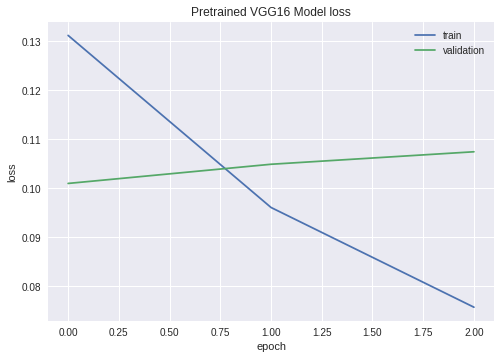

In [26]:
# The schema allows to see if the model was properly fitted
# that allows us to learn if the initial learning rate was appropriate
plt.title("Pretrained VGG16 Model loss")
plt.plot(train_loss, label="train")
plt.plot(val_loss, label="validation")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

## 1.3 ALexNet

In [0]:
torchvision.models.alexnet(pretrained = True)

## Save your model

It might be useful to save your model if you want to continue your work later, or use it for inference later.

In [0]:
torch.save(model.state_dict(), 'model.pkl')

The model file should now be visible in the "Home" screen of the jupyter notebooks interface.  There you should be able to select it and press "download".  [See more here on how to load the model back](https://github.com/pytorch/pytorch/blob/761d6799beb3afa03657a71776412a2171ee7533/docs/source/notes/serialization.rst) if you want to continue training later.

## Download test set

The testset will be made available during the last week before the deadline and can be downloaded in the same way as the training set.

## Predict for test set

You should return your predictions for the test set in a plain text file.  The text file contains one row for each test set image.  Each row contains a binary prediction for each label (separated by a single space), 1 if it's present in the image, and 0 if not. The order of the labels is as follows (alphabetic order of the label names):

    baby bird car clouds dog female flower male night people portrait river sea tree

An example row could like like this if your system predicts the presense of a bird and clouds:

    0 1 0 1 0 0 0 0 0 0 0 0 0 0
    
The order of the rows should be according to the numeric order of the image numbers.  In the test set, this means that the first row refers to image `im20001.jpg`, the second to `im20002.jpg`, and so on.

If you have the prediction output matrix prepared in `y` you can use the following function to save it to a text file.

In [0]:
np.savetxt('results.txt', y, fmt='%d')